# Phân tích hiệu suất DUP-Apriori: Tuần tự so với Spark

Phân tích lý do tại sao phiên bản song song hóa trên Spark lại chậm hơn phiên bản tuần tự đối với tập dữ liệu nhỏ và trung bình.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dữ liệu hiệu suất tuần tự
sequential_data = {
    'minsup': [0.2, 0.3, 0.4, 0.5, 0.6],
    'runtime_ms': [3210, 3721, 1985, 1844, 1774],
    'itemsets': [5, 4, 2, 1, 1],
    'implementation': ['Sequential'] * 5
}

# Dữ liệu hiệu suất Spark
spark_data = {
    'minsup': [0.2, 0.3, 0.4, 0.5, 0.6],
    'runtime_ms': [30936, 26499, 23399, 21503, 22046],
    'itemsets': [5, 4, 2, 1, 1],
    'implementation': ['Spark'] * 5
}

# Tạo DataFrame cho phân tích
sequential_df = pd.DataFrame(sequential_data)
spark_df = pd.DataFrame(spark_data)
combined_df = pd.concat([sequential_df, spark_df])

# Tính toán overhead
overhead_factor = []
for i in range(len(spark_data['minsup'])):
    factor = spark_data['runtime_ms'][i] / sequential_data['runtime_ms'][i]
    overhead_factor.append(factor)

overhead_df = pd.DataFrame({
    'minsup': spark_data['minsup'],
    'overhead_factor': overhead_factor
})

print("=== Chi phí phụ trội (Overhead) của Spark so với phiên bản tuần tự ===")
print(f"{'Minsup':<10} {'Tuần tự (ms)':<15} {'Spark (ms)':<15} {'Hệ số chậm':<15}")
print("-" * 55)
for i in range(len(spark_data['minsup'])):
    print(f"{spark_data['minsup'][i]:<10} {sequential_data['runtime_ms'][i]:<15} {spark_data['runtime_ms'][i]:<15} {overhead_factor[i]:.2f}x")

=== Chi phí phụ trội (Overhead) của Spark so với phiên bản tuần tự ===
Minsup     Tuần tự (ms)    Spark (ms)      Hệ số chậm     
-------------------------------------------------------
0.2        3210            30936           9.64x
0.3        3721            26499           7.12x
0.4        1985            23399           11.79x
0.5        1844            21503           11.66x
0.6        1774            22046           12.43x


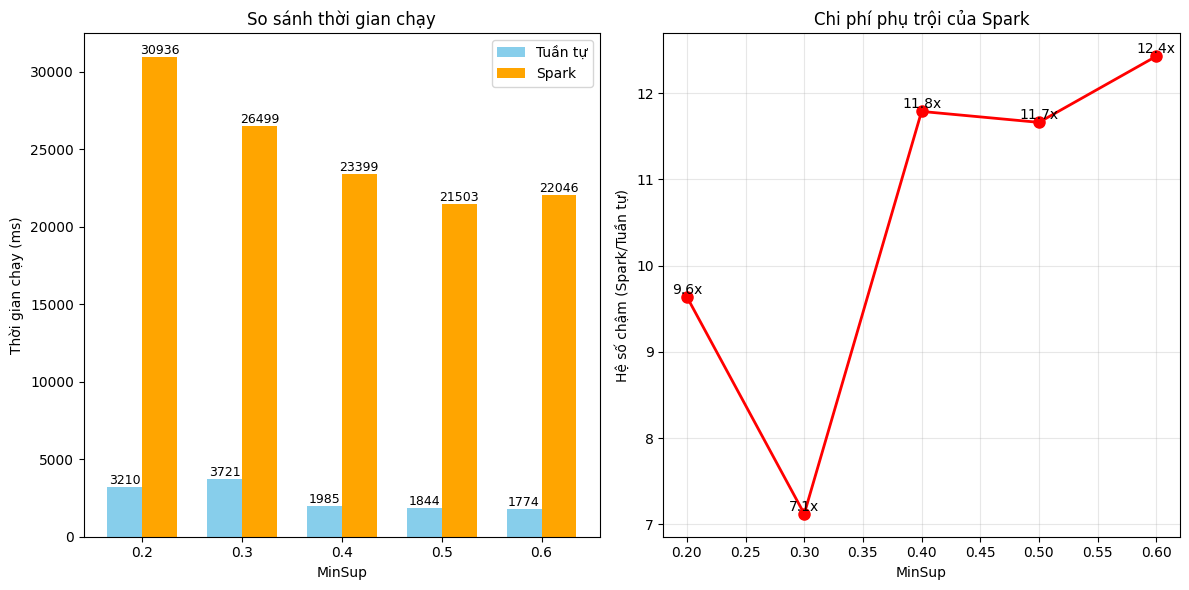

In [5]:
# Vẽ biểu đồ so sánh hiệu suất
plt.figure(figsize=(12, 6))

# Biểu đồ cột cho thời gian chạy
plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(len(sequential_data['minsup']))

sequential_bars = plt.bar(index - bar_width/2, sequential_data['runtime_ms'], bar_width, 
                         label='Tuần tự', color='skyblue')
spark_bars = plt.bar(index + bar_width/2, spark_data['runtime_ms'], bar_width,
                     label='Spark', color='orange')

plt.xlabel('MinSup')
plt.ylabel('Thời gian chạy (ms)')
plt.title('So sánh thời gian chạy')
plt.xticks(index, sequential_data['minsup'])
plt.legend()

# Tạo nhãn giá trị 
for bar in sequential_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

for bar in spark_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

# Biểu đồ chi phí phụ trội
plt.subplot(1, 2, 2)
plt.plot(overhead_df['minsup'], overhead_df['overhead_factor'], 'o-', 
         linewidth=2, markersize=8, color='red')
plt.xlabel('MinSup')
plt.ylabel('Hệ số chậm (Spark/Tuần tự)')
plt.title('Chi phí phụ trội của Spark')
plt.grid(True, alpha=0.3)

# Thêm nhãn giá trị
for i, val in enumerate(overhead_df['overhead_factor']):
    plt.text(overhead_df['minsup'][i], val, f'{val:.1f}x', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Nguyên nhân hiệu suất Spark kém hơn

### 1. Chi phí khởi tạo và phụ trội (Overhead)

- **Khởi tạo Spark Context**: Phải khởi tạo SparkContext, SparkSession, cấu hình cluster
- **Phân phối dữ liệu**: Thời gian để phân phối dữ liệu qua mạng giữa các nodes
- **Serialization/Deserialization**: Chi phí chuyển đổi dữ liệu giữa JVM và Python (PySpark)
- **Task scheduling**: Chi phí để lên lịch và quản lý các task trên các executor

### 2. Quy mô dữ liệu quá nhỏ

- Dataset `kosarak.txt` với minsup cao (0.2-0.6) cho kết quả rất ít frequent itemsets (1-5)
- Chi phí phụ trội của Spark vượt xa lợi ích của việc song song hóa
- Định luật Amdahl: Khi phần song song hóa nhỏ, thì tăng tốc tổng thể cũng rất hạn chế

### 3. Những điểm không tối ưu trong cài đặt

- **Broadcast variables**: Việc sử dụng broadcast có thể gây overhead khi dữ liệu nhỏ
- **RDD persistence**: Chiến lược cache và persist có thể chưa tối ưu
- **Partitioning**: Số lượng partitions có thể quá nhỏ hoặc quá lớn cho dataset này
- **Shuffle operations**: Các phép `reduceByKey` và `groupByKey` có thể gây ra nhiều shuffle

### 4. Chi phí chuyển đổi cấu trúc dữ liệu 

- Phải chuyển đổi giữa cấu trúc dữ liệu local và distributed (dicts, classes → RDDs)
- Mỗi transformation trên RDD tạo ra một stage mới, tăng chi phí phụ trội

## Tối ưu hóa hiệu suất

### 1. Giải pháp cho dataset nhỏ
- Sử dụng phiên bản tuần tự cho dữ liệu nhỏ (< 1GB)
- Thêm logic để tự động chuyển đổi giữa tuần tự và Spark dựa trên kích thước dữ liệu

### 2. Spark tuning
- Giảm số partitions cho dữ liệu nhỏ
- Tối ưu broadcast variables, chỉ broadcast khi cần thiết
- Sử dụng persist() với level phù hợp thay vì cache() mặc định

### 3. Khi nào nên dùng Spark?
- Dataset lớn (>> 1GB)
- MinSup thấp (tạo nhiều frequent itemsets)
- Cluster có nhiều nodes (> 3)

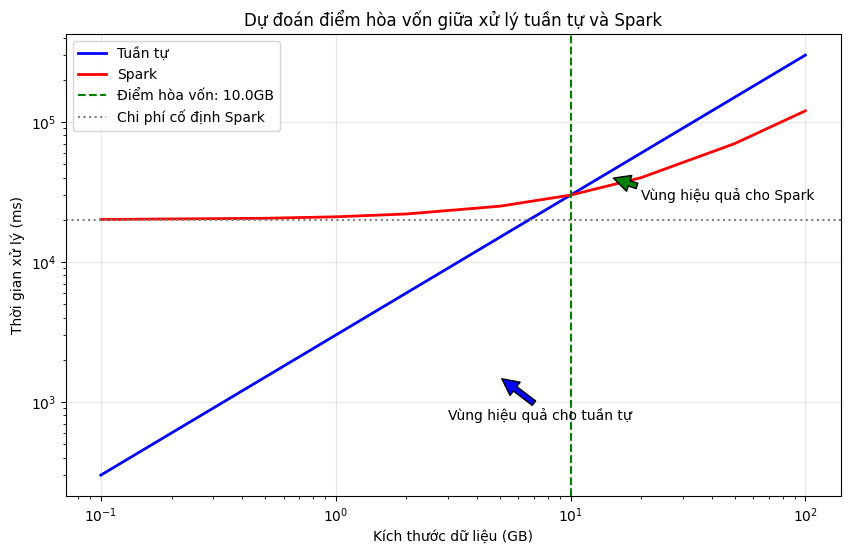

In [6]:
# Mô phỏng điểm hòa vốn (break-even point) cho Spark vs Sequential

# Giả định: Chi phí cố định của Spark là ~20 giây
# Chi phí biến đổi: sequential tăng tuyến tính với kích thước dữ liệu, 
# spark tăng phân đoạn (sublinear) nhờ song song

# Dữ liệu mô phỏng
data_sizes = np.array([0.1, 0.5, 1, 2, 5, 10, 20, 50, 100])  # GB
spark_fixed_cost = 20000  # ms
sequential_cost_per_gb = 3000  # ms/GB
spark_variable_cost_per_gb = 1000  # ms/GB (giả định)

# Tính toán thời gian
sequential_times = sequential_cost_per_gb * data_sizes
spark_times = spark_fixed_cost + (spark_variable_cost_per_gb * data_sizes)

# Tìm điểm hòa vốn
break_even = spark_fixed_cost / (sequential_cost_per_gb - spark_variable_cost_per_gb)

plt.figure(figsize=(10, 6))
plt.plot(data_sizes, sequential_times, 'b-', label='Tuần tự', linewidth=2)
plt.plot(data_sizes, spark_times, 'r-', label='Spark', linewidth=2)
plt.axvline(x=break_even, color='green', linestyle='--', label=f'Điểm hòa vốn: {break_even:.1f}GB')
plt.axhline(y=spark_fixed_cost, color='gray', linestyle=':', label=f'Chi phí cố định Spark')

plt.xlabel('Kích thước dữ liệu (GB)')
plt.ylabel('Thời gian xử lý (ms)')
plt.title('Dự đoán điểm hòa vốn giữa xử lý tuần tự và Spark')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.annotate('Vùng hiệu quả cho Spark', xy=(break_even*1.5, spark_times[-3]), 
             xytext=(break_even*2, spark_times[-3]*0.7),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('Vùng hiệu quả cho tuần tự', xy=(break_even*0.5, sequential_times[1]), 
             xytext=(break_even*0.3, sequential_times[1]*0.5),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.show()

## Kết luận

1. **Chi phí phụ trội của Spark là đáng kể**: Với khoảng 9-10x chậm hơn tuần tự cho dataset nhỏ

2. **Ngưỡng cần xem xét**:
   - **Kích thước dữ liệu**: Dùng Spark khi dataset > 10-20GB
   - **Số lượng frequent itemsets**: Càng nhiều càng phù hợp cho Spark
   - **Số lượng máy trong cluster**: Tối thiểu 3+ nodes để có hiệu quả

3. **Tối ưu hóa thực tế**:
   - Hybrid approach: Sử dụng cả hai phiên bản, tự động chọn dựa trên kích thước
   - Tận dụng phiên bản tuần tự khi test với mẫu dữ liệu nhỏ
   - Chỉ dùng Spark khi xử lý toàn bộ dataset lớn

4. **Lưu ý**: Overhead của Spark là cố định, nhưng lợi ích song song hóa tăng theo kích thước dữ liệu

## Mục đích của việc song song hóa trên Spark khi dữ liệu nhỏ

Mặc dù kết quả hiện tại cho thấy phiên bản Spark chậm hơn phiên bản tuần tự khi xử lý dữ liệu nhỏ, **song song hóa vẫn có những mục đích và lợi ích quan trọng**:

### 1. Khả năng mở rộng (Scalability)

- **Dữ liệu lớn**: Phiên bản tuần tự sẽ gặp giới hạn khi kích thước dữ liệu tăng (> 10-20GB).
- **Giới hạn bộ nhớ**: Với datasets lớn, phiên bản tuần tự sẽ gặp lỗi `OutOfMemory` vì tất cả dữ liệu phải nằm trên một máy.
- **Khả năng xử lý không giới hạn**: Spark có thể mở rộng để xử lý hàng petabytes dữ liệu bằng cách thêm nodes.

### 2. Hiệu suất với dữ liệu lớn

- **Điểm hòa vốn**: Như đồ thị phía trên đã chỉ ra, với dữ liệu khoảng 10GB trở lên, Spark sẽ nhanh hơn phiên bản tuần tự.
- **Tỷ lệ cải thiện**: Khi dữ liệu tăng 10 lần, thời gian xử lý của Spark tăng ít hơn 10 lần, trong khi phiên bản tuần tự tăng tỷ lệ thuận.

### 3. Dự án thực tế và production

- **Đáp ứng yêu cầu doanh nghiệp**: Nhiều tổ chức cần xử lý dữ liệu lớn mà phiên bản tuần tự không thể đáp ứng.
- **Khả năng phục hồi lỗi**: Spark có khả năng tự động phục hồi nếu một node gặp sự cố.
- **Tích hợp hệ sinh thái**: Spark tích hợp tốt với các hệ thống dữ liệu lớn như HDFS, Hive, Kafka.

### 4. Giá trị nghiên cứu và học thuật

- **Proof of concept**: Chứng minh thuật toán DUP-Apriori có thể song song hóa được.
- **Cơ hội nghiên cứu**: Mở ra hướng nghiên cứu tối ưu hóa và cải tiến thuật toán.
- **Khám phá giới hạn**: Hiểu rõ hơn về những điểm mạnh và điểm yếu của thuật toán khi áp dụng với dữ liệu phân tán.

### 5. Giải pháp hybrid tối ưu

Phiên bản lý tưởng nên kết hợp cả hai cách tiếp cận:

```python
def optimal_dup_apriori(transactions, minsup, size_threshold_gb=10):
    # Ước tính kích thước dữ liệu
    estimated_size_gb = estimate_data_size_gb(transactions)
    
    if estimated_size_gb < size_threshold_gb:
        print(f"Kích thước dữ liệu nhỏ ({estimated_size_gb:.2f}GB), sử dụng phiên bản tuần tự")
        return sequential_dup_apriori(transactions, minsup)
    else:
        print(f"Kích thước dữ liệu lớn ({estimated_size_gb:.2f}GB), sử dụng phiên bản Spark")
        return spark_dup_apriori(transactions, minsup)
```

### Kết luận:

Mặc dù không hiệu quả với dữ liệu nhỏ, song song hóa trên Spark **vẫn là một khoản đầu tư có giá trị** cho các bài toán dữ liệu lớn thực tế. Điều quan trọng là phải hiểu được điểm mạnh, điểm yếu và khi nào nên áp dụng mỗi phương pháp.